16008450 Inés Alarcón

##Laboratorio #3: Ingeniería de Características

Para el dataset adjunto, realice las siguientes operaciones de ingeniería de
características:

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import MissingIndicator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

In [102]:
df = pd.read_csv('hotel_data.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          101482 non-null  float64
 10  children                        109835 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

1. Determine que columnas poseen faltantes (NA o Nulos)

In [103]:
columns_with_nulls = df.columns[df.isnull().any()]
for col in columns_with_nulls:
    print(f"Columna '{col}' tiene {df[col].isnull().sum()} valores nulos.")

Columna 'adults' tiene 17908 valores nulos.
Columna 'children' tiene 9555 valores nulos.
Columna 'country' tiene 488 valores nulos.
Columna 'distribution_channel' tiene 26265 valores nulos.
Columna 'agent' tiene 16340 valores nulos.
Columna 'company' tiene 112593 valores nulos.
Columna 'adr' tiene 19102 valores nulos.


2. Determine la proporción de faltantes para cada columna con faltantes, muestre una gráfica de barras con el porcentaje de faltantes para cada columna.

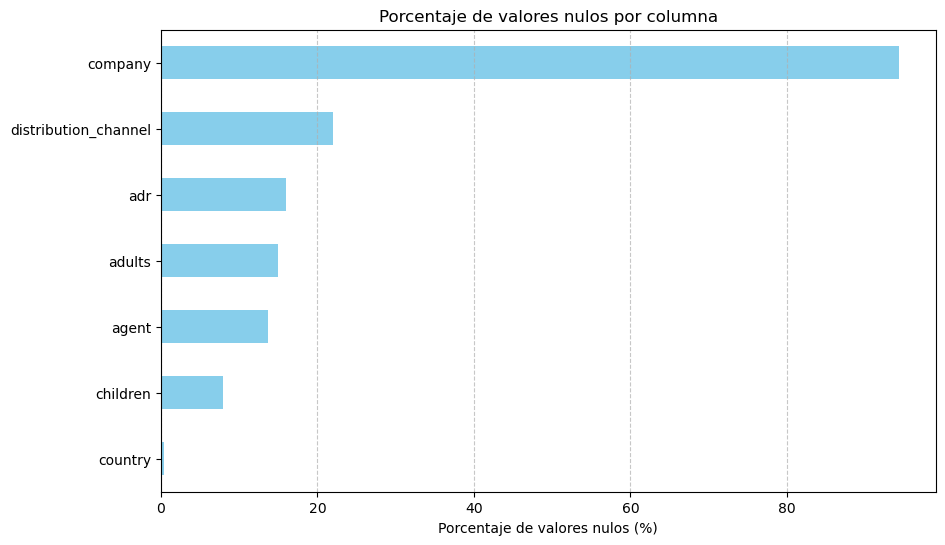

In [104]:
null_counts = df.isnull().sum() / len(df) * 100
null_counts = null_counts[null_counts > 0] 

plt.figure(figsize=(10, 6))
null_counts.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.title('Porcentaje de valores nulos por columna')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

3. Si la variable es numérica realice un análisis de cual sería el mejor método para realizar la imputación de datos, debe implementar un bloque de código donde se muestre cada imputación y su análisis. Recuerde que puede ser:
    a. Análisis de casos completos (CCA),
    b. Imputación de media
    c. Imputación de mediana,
    d. Generación de números aleatorios en base a la distribución (no visto en clase – opcional).

In [105]:
numeric_cols_with_missing = df.select_dtypes(include=np.number).columns[df.select_dtypes(include=np.number).isnull().any()]

strategies = ['mean', 'median', 'most_frequent', 'constant']
imputers = {}

for strategy in strategies:
    if strategy == 'constant':
        imputer = SimpleImputer(strategy=strategy, fill_value=-999)  # Ejemplo de valor constante
    else:
        imputer = SimpleImputer(strategy=strategy)
    
    df_imputed = df.copy()
    df_imputed[numeric_cols_with_missing] = imputer.fit_transform(df[numeric_cols_with_missing])
    
    print(f"Estrategia: {strategy}")
    
    null_rows = df[numeric_cols_with_missing].isnull().any(axis=1)
    print("Valores imputados:")
    print(df_imputed.loc[null_rows, numeric_cols_with_missing])
    
    print("Estadísticas descriptivas antes de la imputación:")
    print(df[numeric_cols_with_missing].describe())
    print("Estadísticas descriptivas después de la imputación:")
    print(df_imputed[numeric_cols_with_missing].describe())
    print("=" * 50)

    imputers[strategy] = imputer

Estrategia: mean
Valores imputados:
        adults  children       agent     company         adr
0          2.0  0.104029   86.693382  189.266735    0.000000
1          2.0  0.104029   86.693382  189.266735    0.000000
2          1.0  0.000000   86.693382  189.266735  101.943582
3          1.0  0.000000  304.000000  189.266735  101.943582
4          2.0  0.000000  240.000000  189.266735  101.943582
...        ...       ...         ...         ...         ...
119385     2.0  0.000000  394.000000  189.266735  101.943582
119386     3.0  0.000000    9.000000  189.266735  101.943582
119387     2.0  0.000000    9.000000  189.266735  101.943582
119388     2.0  0.000000   89.000000  189.266735  104.400000
119389     2.0  0.000000    9.000000  189.266735  151.200000

[119239 rows x 5 columns]
Estadísticas descriptivas antes de la imputación:
              adults       children          agent      company            adr
count  101482.000000  109835.000000  103050.000000  6797.000000  100288.0000

4. Si la variable es categórica, realice una imputación que considere necesaria, recuerde tomar en cuenta los siguientes aspectos:
    a. Impacto sobre la variable target.
    b. Recuerde que el valor que más se repite no necesariamente es el valor que
    se debe imputar.
    c. Indicador de clase faltante (Missing indicator).

In [106]:
cat_cols_with_missing = df.select_dtypes(include='object').columns[df.select_dtypes(include='object').isnull().any()]

class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='most_frequent', missing_indicator=False):
        self.strategy = strategy
        self.missing_indicator = missing_indicator
        self.imputer = SimpleImputer(strategy=self.strategy)
        
    def fit(self, X, y=None):
        self.imputer.fit(X)
        if self.missing_indicator:
            self.missing_values_ = pd.isnull(X).any(axis=1).values.reshape(-1, 1)
        return self
    
    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        if self.missing_indicator:
            X_imputed = np.hstack((X_imputed, self.missing_values_))
        return X_imputed

cat_pipeline = Pipeline([
    ('imputer', CustomImputer(strategy='most_frequent', missing_indicator=True)),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

cat_transformed = cat_pipeline.fit_transform(df[cat_cols_with_missing])

cat_feature_names = cat_pipeline.named_steps['encoder'].categories_
cat_feature_names = np.concatenate(cat_feature_names)

cat_transformed_df = pd.DataFrame(cat_transformed.toarray(), columns=cat_feature_names)

df_imputed = pd.concat([df.drop(columns=cat_cols_with_missing), cat_transformed_df], axis=1)

print("DataFrame imputado:")
print(df_imputed.head())

DataFrame imputado:
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  ZAF  ZMB  ZWE  \
0                        0                     0     2.0  ...  0

5. Realice la codificación de variables categóricas, determine cual es le mejor enfoque para cada caso, recuerde que puede realizar los siguientes enfoques:
    a. One Hote Encodign.
    b. Codificación por Frecuencia.
    c. Codificación por Densidad.

In [107]:
cat_cols = [
    'hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
    'distribution_channel', 'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date'
]

cat_cols_existing = [col for col in cat_cols if col in df.columns]

ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_encoded = ohe_encoder.fit_transform(df[cat_cols_existing])

cat_feature_names = ohe_encoder.get_feature_names_out(input_features=cat_cols_existing)

cat_encoded_df = pd.DataFrame(cat_encoded, columns=cat_feature_names)

df_encoded = pd.concat([df.drop(columns=cat_cols_existing), cat_encoded_df], axis=1)

print("DataFrame con variables categóricas codificadas:")
print(df_encoded.head())

C:\Users\inesa\Anaconda 3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


DataFrame con variables categóricas codificadas:
   is_canceled  lead_time  arrival_date_year  arrival_date_week_number  \
0            0        342               2015                        27   
1            0        737               2015                        27   
2            0          7               2015                        27   
3            0         13               2015                        27   
4            0         14               2015                        27   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                          1                        0                     0   
1                          1                        0                     0   
2                          1                        0                     1   
3                          1                        0                     1   
4                          1                        0                     2   

   adults  children  babies  ..

6. Identifique cuales variables son discretas y continuas.

In [108]:
discrete_vars = [
    'is_canceled', 'arrival_date_year', 'arrival_date_week_number',
    'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
    'required_car_parking_spaces', 'total_of_special_requests'
]

continuous_vars = [
    'lead_time', 'adr'
]

print("Variables Discretas:")
print(discrete_vars)
print("\nVariables Continuas:")
print(continuous_vars)


Variables Discretas:
['is_canceled', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']

Variables Continuas:
['lead_time', 'adr']


7. Para las variables que se consideren continuas aplique el tratamiento de Outliers, recuerde que puede aplicar los siguientes métodos
    a. Capping de final de cola.
    b. Capping de valor arbitrario.

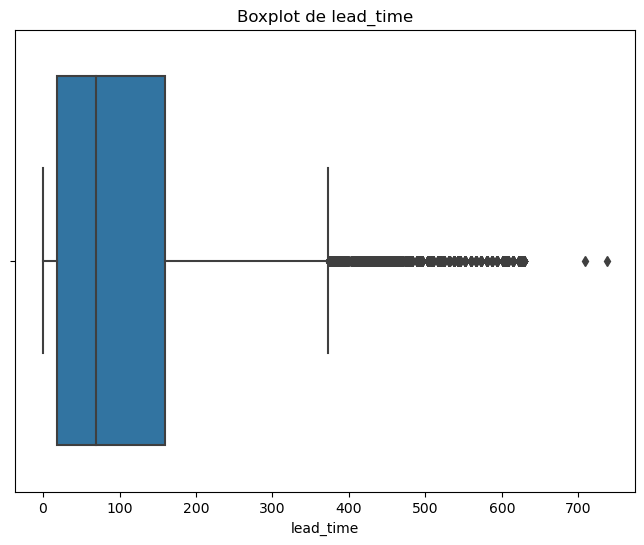

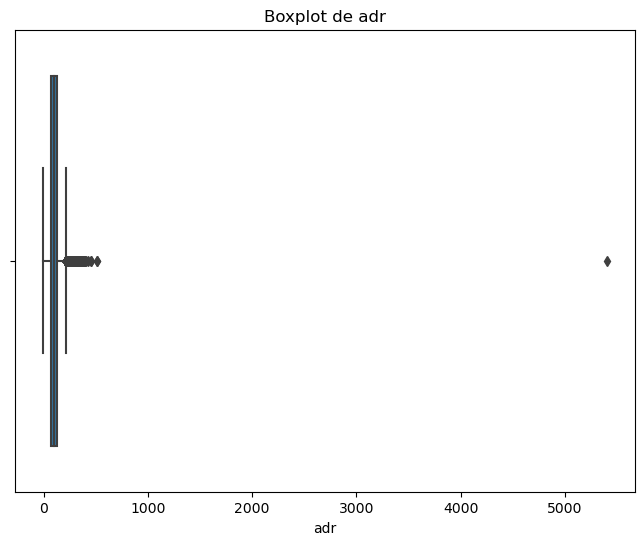

In [109]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='lead_time', data=df)
plt.title('Boxplot de lead_time')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='adr', data=df)
plt.title('Boxplot de adr')
plt.show()

lead_time_upper_limit = df['lead_time'].quantile(0.99)
df['lead_time'] = df['lead_time'].apply(lambda x: lead_time_upper_limit if x > lead_time_upper_limit else x)

adr_upper_limit = df['adr'].quantile(0.99)
df['adr'] = df['adr'].apply(lambda x: adr_upper_limit if x > adr_upper_limit else x)

lead_time_cap_value = 400
df['lead_time'] = df['lead_time'].apply(lambda x: lead_time_cap_value if x > lead_time_cap_value else x)

adr_cap_value = 500
df['adr'] = df['adr'].apply(lambda x: adr_cap_value if x > adr_cap_value else x)

8. Posteriormente para las variables tratadas con outliers, verifique la forma de la distribución y determine si es necesario aplicar algún tipo de transformación de variables para mejorar la forma de las distribuciones.

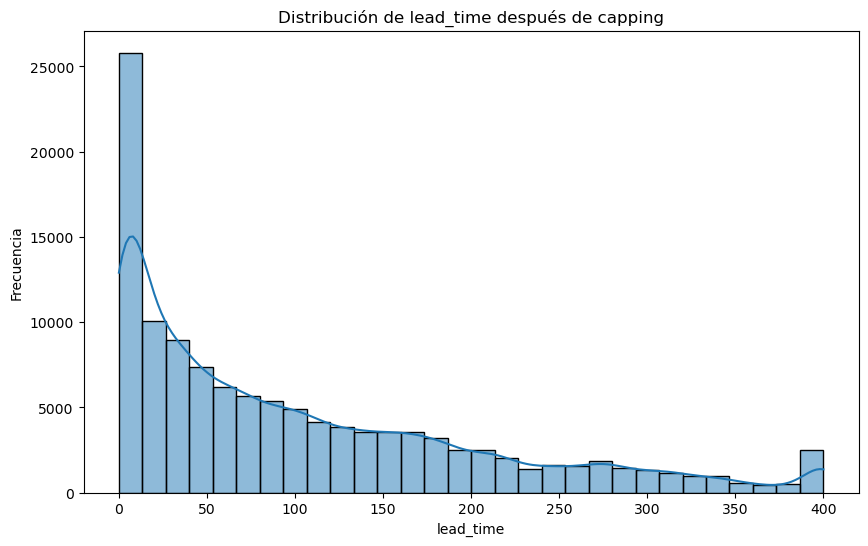

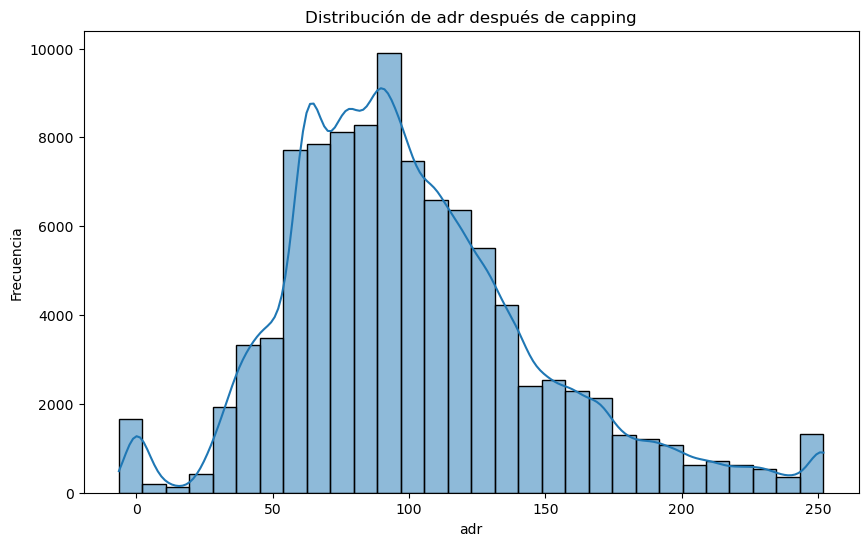

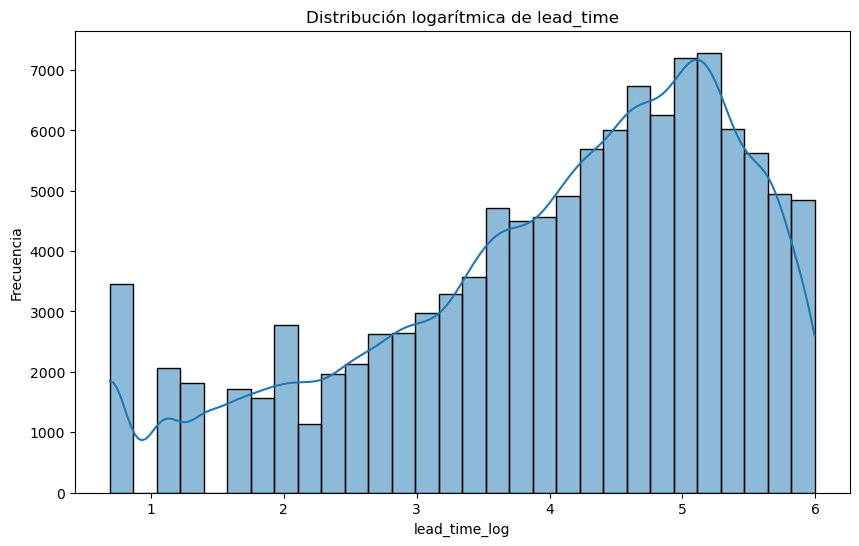

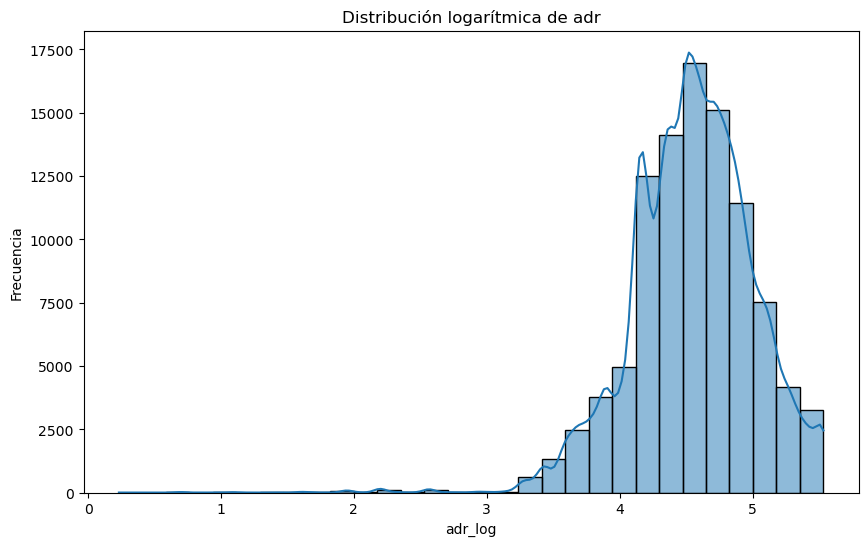

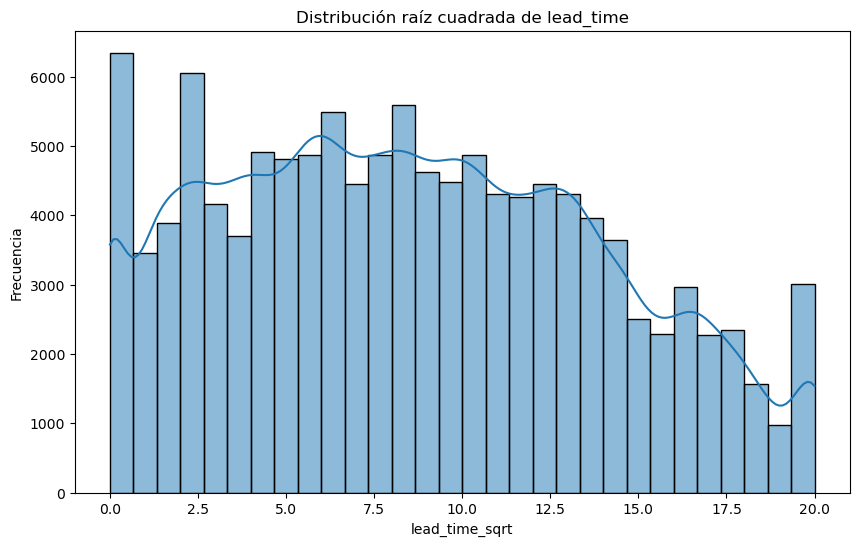

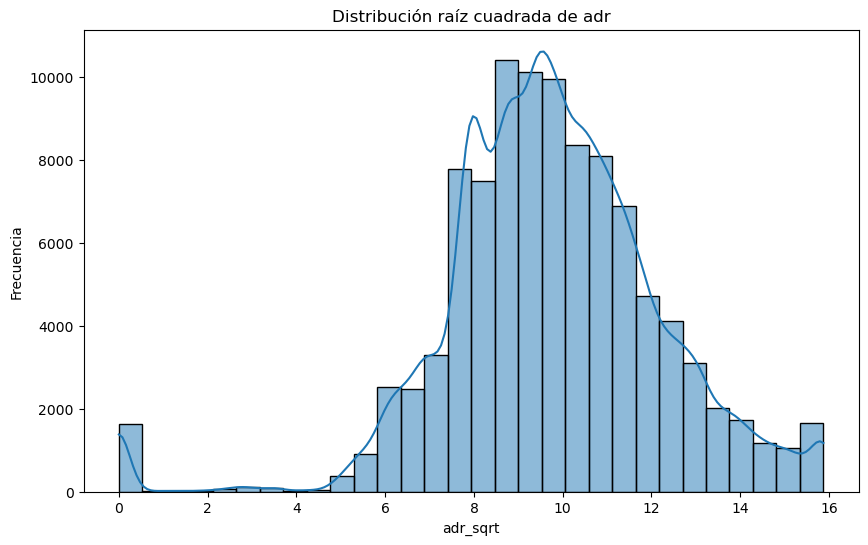

In [110]:
# Histograma de lead_time
plt.figure(figsize=(10, 6))
sns.histplot(df['lead_time'], bins=30, kde=True)
plt.title('Distribución de lead_time después de capping')
plt.xlabel('lead_time')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de adr
plt.figure(figsize=(10, 6))
sns.histplot(df['adr'], bins=30, kde=True)
plt.title('Distribución de adr después de capping')
plt.xlabel('adr')
plt.ylabel('Frecuencia')
plt.show()

df['lead_time_log'] = np.log1p(df['lead_time'][df['lead_time'] > 0])

# Aplicar transformación logarítmica a adr
df['adr_log'] = np.log1p(df['adr'][df['adr'] > 0])

# Visualización de las distribuciones transformadas
plt.figure(figsize=(10, 6))
sns.histplot(df['lead_time_log'], bins=30, kde=True)
plt.title('Distribución logarítmica de lead_time')
plt.xlabel('lead_time_log')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['adr_log'], bins=30, kde=True)
plt.title('Distribución logarítmica de adr')
plt.xlabel('adr_log')
plt.ylabel('Frecuencia')
plt.show()

# Aplicar transformación de raíz cuadrada a lead_time
df['lead_time_sqrt'] = np.sqrt(df['lead_time'][(df['lead_time'] >= 0) & (~df['lead_time'].isna())])

# Aplicar transformación de raíz cuadrada a adr
df['adr_sqrt'] = np.sqrt(df['adr'][(df['adr'] >= 0) & (~df['adr'].isna())])

# Visualización de las distribuciones transformadas
plt.figure(figsize=(10, 6))
sns.histplot(df['lead_time_sqrt'], bins=30, kde=True)
plt.title('Distribución raíz cuadrada de lead_time')
plt.xlabel('lead_time_sqrt')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['adr_sqrt'], bins=30, kde=True)
plt.title('Distribución raíz cuadrada de adr')
plt.xlabel('adr_sqrt')
plt.ylabel('Frecuencia')
plt.show()

9. De ser el caso aplique la transformación que considere pertinente a fin de normalizar lo más posible la distribución de probabilidad de cada variable y mejorar el rendimiento del modelo. Recuerde que puede aplicar las siguientes transformaciones:
    a. Logarítmica,
    b. Exponencial,
    c. Polinomial,
    d. Box-Cox,
    e. Yeo-Johnson.

In [111]:
numeric_cols = df.select_dtypes(include=np.number).columns

df['lead_time_log'] = np.log1p(df['lead_time'])

df['adr_exp'] = np.exp(df['adr'])

pt = PowerTransformer(method='yeo-johnson')
df['days_in_waiting_list_yj'] = pt.fit_transform(df[['days_in_waiting_list']])

print(df[['lead_time', 'lead_time_log', 'adr', 'adr_exp', 'days_in_waiting_list', 'days_in_waiting_list_yj']].head())

   lead_time  lead_time_log  adr  adr_exp  days_in_waiting_list  \
0      342.0       5.837730  0.0      1.0                     0   
1      400.0       5.993961  0.0      1.0                     0   
2        7.0       2.079442  NaN      NaN                     0   
3       13.0       2.639057  NaN      NaN                     0   
4       14.0       2.708050  NaN      NaN                     0   

   days_in_waiting_list_yj  
0                -0.178785  
1                -0.178785  
2                -0.178785  
3                -0.178785  
4                -0.178785  


10. Finalmente una vez aplicadas todas las transformaciones descritas anteriormente, deberá aplicar el escalado de variables a todo el dataset. Recuerde que puede aplicar los siguientes tipos de feature scaling.
    a. MinMax Scaling.
    b. Standar Scaling.
    c. MaxAbs Scaling.
    d. Robust Scaling.

In [112]:
numeric_cols = df.select_dtypes(include=np.number).columns

scaler_minmax = MinMaxScaler()
df_scaled_minmax = df.copy()
df_scaled_minmax[numeric_cols] = scaler_minmax.fit_transform(df[numeric_cols])

scaler_standard = StandardScaler()
df_scaled_standard = df.copy()
df_scaled_standard[numeric_cols] = scaler_standard.fit_transform(df[numeric_cols])

scaler_maxabs = MaxAbsScaler()
df_scaled_maxabs = df.copy()
df_scaled_maxabs[numeric_cols] = scaler_maxabs.fit_transform(df[numeric_cols])

scaler_robust = RobustScaler()
df_scaled_robust = df.copy()
df_scaled_robust[numeric_cols] = scaler_robust.fit_transform(df[numeric_cols])

print("MinMax Scaled DataFrame:")
print(df_scaled_minmax.head())

print("\nStandard Scaled DataFrame:")
print(df_scaled_standard.head())

print("\nMaxAbs Scaled DataFrame:")
print(df_scaled_maxabs.head())

print("\nRobust Scaled DataFrame:")
print(df_scaled_robust.head())

MinMax Scaled DataFrame:
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel          0.0     0.8550                0.0               July   
1  Resort Hotel          0.0     1.0000                0.0               July   
2  Resort Hotel          0.0     0.0175                0.0               July   
3  Resort Hotel          0.0     0.0325                0.0               July   
4  Resort Hotel          0.0     0.0350                0.0               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                       0.5                        0.0   
1                       0.5                        0.0   
2                       0.5                        0.0   
3                       0.5                        0.0   
4                       0.5                        0.0   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                      0.0                  0.00    0.04  ...   
1        